<h1 style = 'color: orange'> Taxi Company - Crazy Run - S13  </h1>

A empresa Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. 

Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 

Construa um modelo para tal predição.

Diretrizes:

-   Faça download dos dados e faça uma nova amostragem deles de forma que cada ponto dos dados originais fique dentro de intervalos de uma hora;
-   Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial;
-   A métrica REQM no conjunto de teste não deve ser superior a 48;
-   Teste os dados usando a amostra de teste e forneça uma conclusão.

<h2 style = 'color: orange'> Initialization  </h2>

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

from scipy import stats as st

import math

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import textwrap

sns.set_theme(style="whitegrid")

from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.linear_model

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

from numpy.linalg import LinAlgError

from IPython.display import display

from catboost import CatBoostRegressor

import time

from statsmodels.tsa.statespace.sarimax import SARIMAX


<h2 style = 'color: orange'> Reading Files:</h2>

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<h2 style = 'color: orange'> Data preprocessing:</h2>

In [6]:
df.sort_index(inplace=True)

In [7]:
df.index.is_monotonic_increasing

True

In [8]:
# Resampling the data (for each hour).

df_hour = df.resample('1H').sum()

In [9]:
df_hour

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


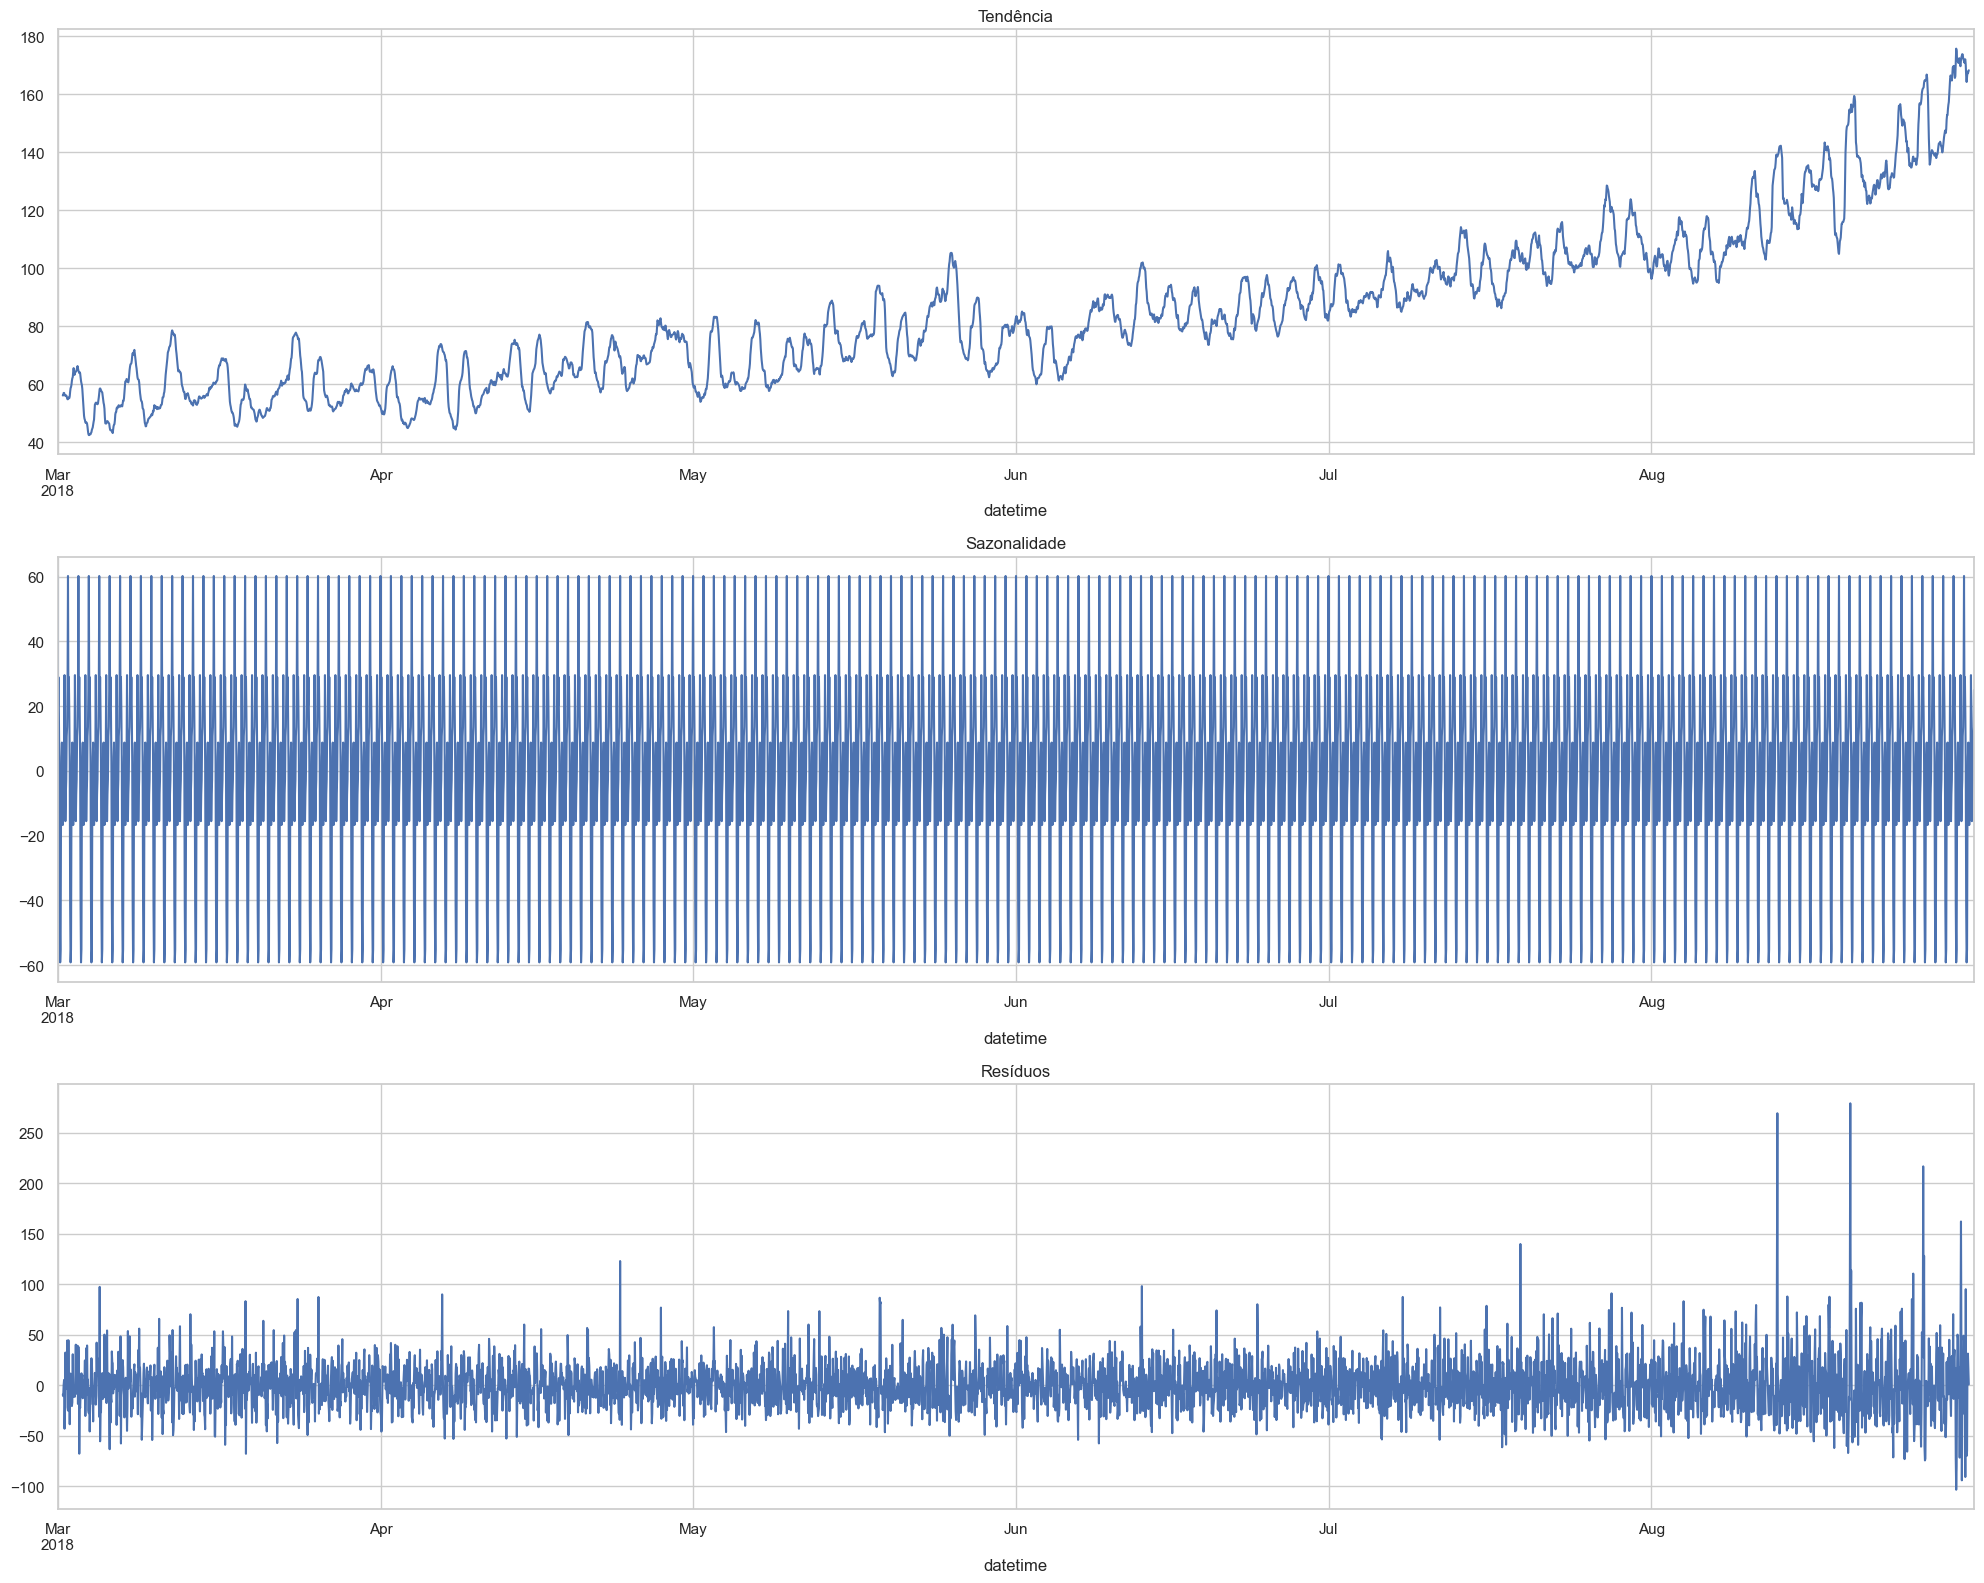

In [10]:
# Analyzing trend, seasonality and resid:

decomposed = seasonal_decompose(df_hour['num_orders'])

plt.figure(figsize=(20, 16))

plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resid')

plt.tight_layout()

Destaco dos gráficos a tendência de crescimento no número de pedidos e a quantidade de ruídos que terá que ser tratada para viabilizar um modelo com bom desempenho.

In [11]:
# Including columns for residual treatments:

result = seasonal_decompose(df_hour['num_orders'], model='additive', period=24)

df_hour['trend'] = result.trend
df_hour['seasonal'] = result.seasonal
df_hour['residual'] = result.resid

In [12]:
df_hour.isna().mean()

num_orders    0.000000
trend         0.005435
seasonal      0.000000
residual      0.005435
dtype: float64

In [13]:
df_hour = df_hour.dropna()

In [14]:
# Define function to identify and replace outliers based on trend and seasonality:

def replace_outliers(data, residual_col='residual', trend_col='trend', seasonal_col='seasonal', threshold=3):
    
    residuals = data[residual_col]
    trend = data[trend_col]
    seasonal = data[seasonal_col]
    
    mean_residual = residuals.mean()
    std_residual = residuals.std()
    
    outliers = (residuals - mean_residual).abs() > threshold * std_residual
    
    num_altered = outliers.sum()
    
    data.loc[outliers, 'num_orders'] = trend[outliers] + seasonal[outliers]
    
    return data, num_altered


df_hour, num_altered = replace_outliers(df_hour)

print(f'Number of lines changed: {num_altered}')


Number of lines changed: 46


In [15]:
df_hour.isna().mean()

num_orders    0.0
trend         0.0
seasonal      0.0
residual      0.0
dtype: float64

O tratamento dos outliers baseados na média e desvio padrão dos resíduos tratou dados de 46 linhas do DF. É um percentual pequeno, porém são dados que durante a execução do modelo podem elevar o valor do RMSE prejudicando a avaliação do desempenho.

Irei criar colunas (features) sempre independentes da coluna 'target' para assim evitar vazamento de dados para o modelo. O uso de média móvel com valores mais elevados e um grupo robusto de 'lags' ajudará a evidenciar a tendência da evolução dos dados (que acredito ser o grande desafio desse trabalho).

In [16]:
# Creating Features:

def make_features(data, max_lag, rolling_mean_size_1, rolling_mean_size_2, rolling_mean_size_3):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['year'] = data.index.year
        
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean_1'] = data['num_orders'].shift().rolling(rolling_mean_size_1).mean()
    data['rolling_mean_2'] = data['num_orders'].shift().rolling(rolling_mean_size_2).mean()
    data['rolling_mean_3'] = data['num_orders'].shift().rolling(rolling_mean_size_3).mean()


make_features(df_hour, 50, 24, 120, 240)

In [17]:
df_hour.isna().sum()

num_orders          0
trend               0
seasonal            0
residual            0
hour                0
                 ... 
lag_49             49
lag_50             50
rolling_mean_1     24
rolling_mean_2    120
rolling_mean_3    240
Length: 62, dtype: int64

In [18]:
df_hour = df_hour.dropna()

In [19]:
df_hour.shape

(4152, 62)

<h2 style = 'color: orange'> Data visualization:</h2>

Nos gráficos abaixo, demonstro a tendência evolutiva dos dados capturada pela 'rolling_mean_2' e faço um 'zoom' em uma fatia dos dados para observar o comportamento dos dados em intervalos diários.

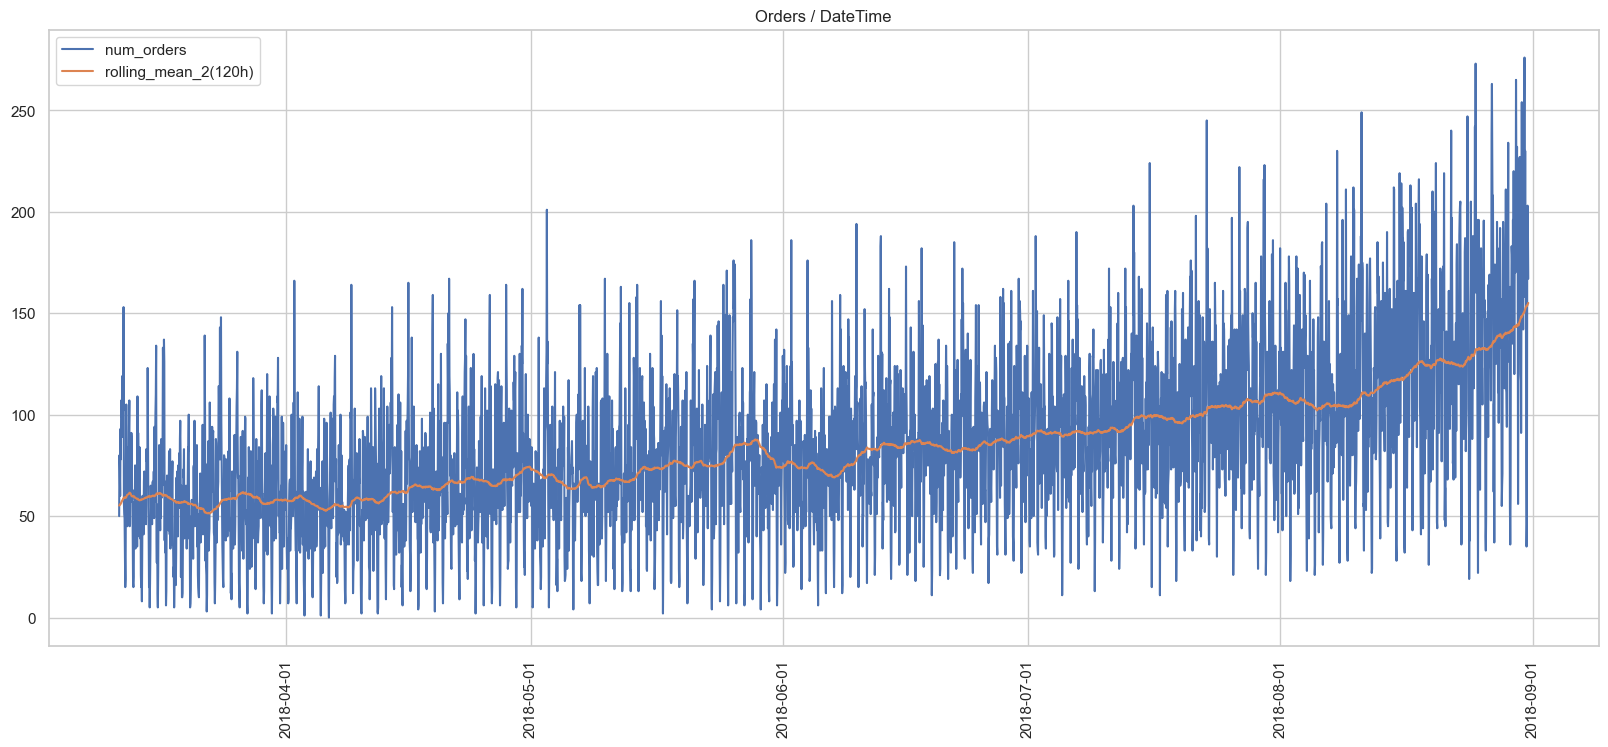

In [20]:
fig, (ax1) = plt.subplots(1, figsize=(20, 8))

sns.lineplot(data = df_hour['num_orders'], ax = ax1, label='num_orders');
sns.lineplot(data = df_hour, x=df_hour.index, y='rolling_mean_2', ax = ax1, label='rolling_mean_2(120h)');

ax1.set_title("Orders / DateTime");
ax1.set_xlabel("");
ax1.set_ylabel("");
ax1.xaxis.set_major_locator(mdates.MonthLocator()) 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90);

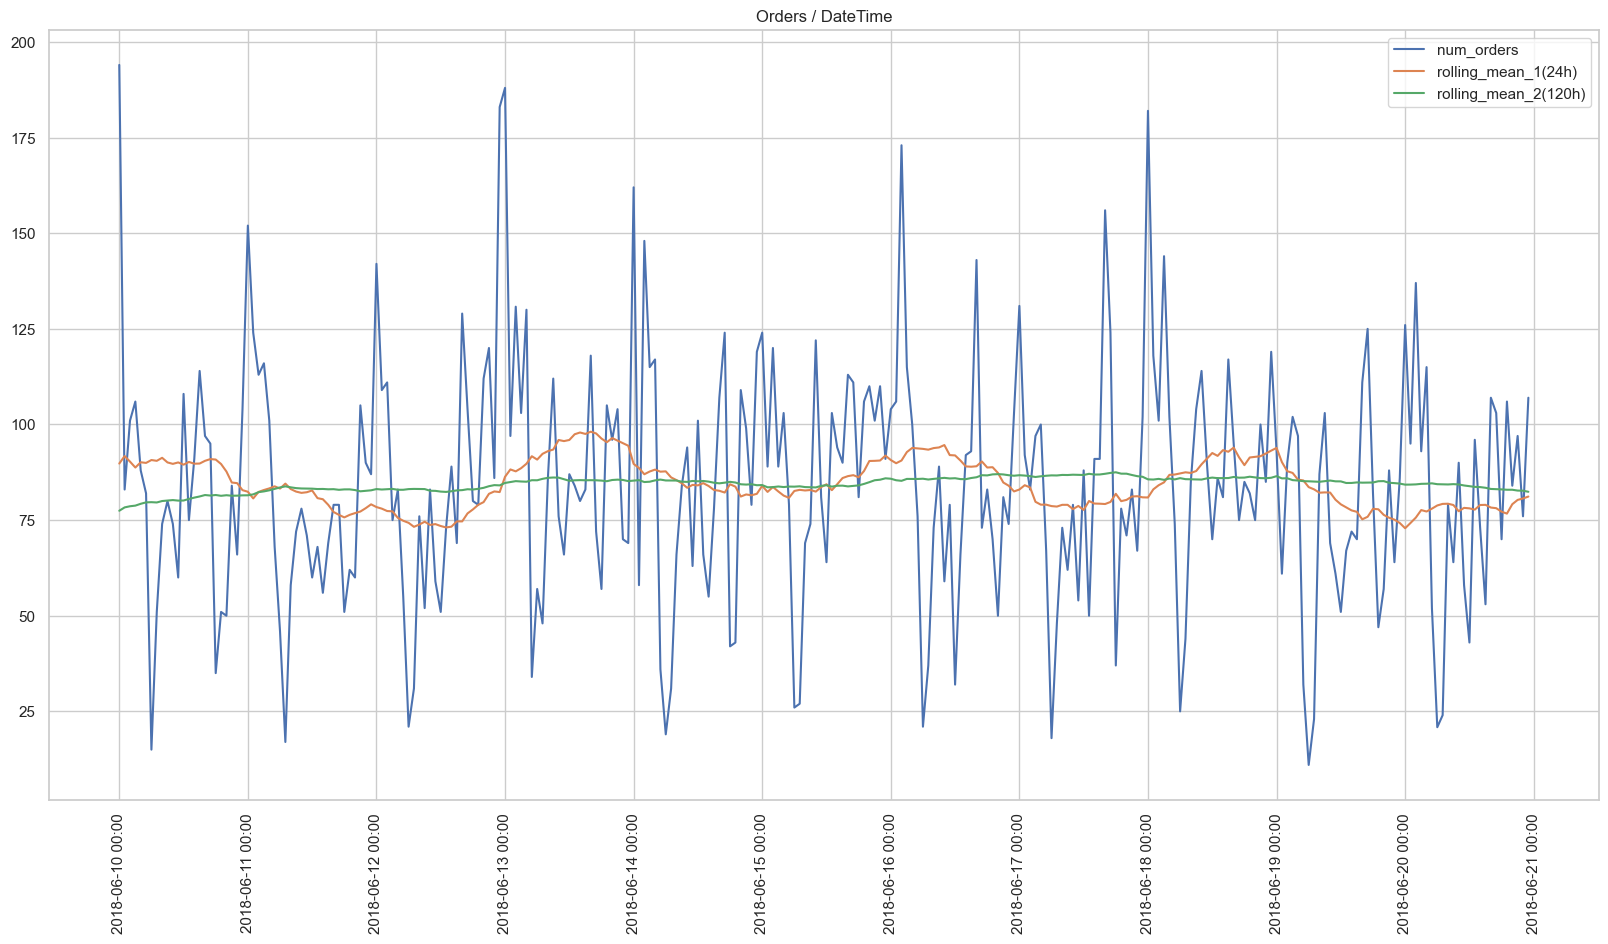

In [21]:
filtered_df = df_hour['2018-06-10 00:00:00':'2018-06-20 23:00:00']

fig, (ax1) = plt.subplots(1, figsize=(20, 10))

sns.lineplot(data = filtered_df, x=filtered_df.index, y='num_orders', ax = ax1, label='num_orders');
sns.lineplot(data = filtered_df, x=filtered_df.index, y='rolling_mean_1', ax = ax1, label='rolling_mean_1(24h)');
sns.lineplot(data = filtered_df, x=filtered_df.index, y='rolling_mean_2', ax = ax1, label='rolling_mean_2(120h)');

ax1.set_title("Orders / DateTime");
ax1.set_xlabel("");
ax1.set_ylabel("");
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 24)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90);

<h2 style = 'color: orange'> ML:</h2>

Começo a etapa do ML excluindo as colunas baseadas na coluna 'target' para evitar vazamento de dados e separando os dados para os modelos. 

Irei utilizar os modelos:

-   Linear Regression;
-   Random Forest Regressor;
-   CatBOOST.

Ambos com seleção de hiperparâmetros por Grid CV.

In [22]:
# Excluding columns based on target column to avoid data leakage:

df_hour = df_hour.drop(['trend', 'seasonal', 'residual'], axis=1)

In [23]:
df_hour.head(3)

,num_orders,hour,day,dayofweek,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean_1,rolling_mean_2,rolling_mean_3
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-11 12:00:00,50.0,12,11,6,3,2018,51.0,56.0,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0,83.0,81.0,73.0,80.0,62.0,54.0,33.0,102.0,60.0,53.0,93.0,37.0,47.0,34.0,58.0,48.0,43.0,46.0,18.0,5.0,12.0,46.0,44.0,24.0,78.0,117.0,49.0,82.0,70.0,60.0,48.0,39.0,66.0,59.0,44.0,55.0,48.0,24.0,49.0,43.0,52.666667,55.225000,53.606380
2018-03-11 13:00:00,80.0,13,11,6,3,2018,50.0,51.0,56.0,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0,83.0,81.0,73.0,80.0,62.0,54.0,33.0,102.0,60.0,53.0,93.0,37.0,47.0,34.0,58.0,48.0,43.0,46.0,18.0,5.0,12.0,46.0,44.0,24.0,78.0,117.0,49.0,82.0,70.0,60.0,48.0,39.0,66.0,59.0,44.0,55.0,48.0,24.0,49.0,53.333333,55.300000,53.689714
2018-03-11 14:00:00,72.0,14,11,6,3,2018,80.0,50.0,51.0,56.0,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0,83.0,81.0,73.0,80.0,62.0,54.0,33.0,102.0,60.0,53.0,93.0,37.0,47.0,34.0,58.0,48.0,43.0,46.0,18.0,5.0,12.0,46.0,44.0,24.0,78.0,117.0,49.0,82.0,70.0,60.0,48.0,39.0,66.0,59.0,44.0,55.0,48.0,24.0,54.708333,55.616667,53.889714


In [24]:
# Splitting the data into training (80%), validation (10%) and testing (10%) sets:

train, valid_test = train_test_split(df_hour, test_size=0.2, shuffle=False)

valid, test = train_test_split(valid_test, test_size=0.5, shuffle=False)

In [25]:
# Declaring variables for 'features' and 'target':

features_train = train.drop(['num_orders', 'year'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders', 'year'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders', 'year'], axis=1)
target_test = test['num_orders']

<h4 style = 'color: orange'>Linear Regression:</h4>

In [26]:
param_grid = {
    'fit_intercept': [True, False],       
}

model = LinearRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

predictions_valid = grid_search.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
print("RMSE:", np.sqrt(mse_valid))

Best Parameters: {'fit_intercept': False}
RMSE: 27.30579081146743


<h4 style = 'color: orange'>Random Forest Regressor with Grid Search CV:</h4>

In [27]:
param_grid = {  
    'max_depth': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],  
    'min_samples_leaf': [1, 2, 4],  
    'min_samples_split': [1, 2, 4],
    'n_estimators': [50, 100, 150],    
}

model = RandomForestRegressor(random_state=54321)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = RandomForestRegressor(**best_params, random_state=54321)
best_model.fit(features_train, target_train)

predictions_valid = best_model.predict(features_valid)

mse_valid = mean_squared_error(target_valid, predictions_valid)
print("RMSE:", np.sqrt(mse_valid))

Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 26.722998016776078


<h4 style = 'color: orange'>CatBoost with Grid Search CV::</h4>

In [28]:
param_grid = {
    'n_estimators': [30, 50, 100],              
    'learning_rate': [0.01, 0.1, 0.2],           
    'depth': [5, 10, 15],                       
    'subsample': [0.8, 0.9, 1.0],               
    'min_data_in_leaf': [10, 20],              
    'colsample_bylevel': [0.8, 1.0]            
}

model = CatBoostRegressor(random_state=12345, silent=True)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

predictions_valid = best_model.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
print("RMSE:", np.sqrt(mse_valid))


Best Hyperparameters: {'colsample_bylevel': 1.0, 'depth': 5, 'learning_rate': 0.1, 'min_data_in_leaf': 10, 'n_estimators': 100, 'subsample': 1.0}
RMSE: 26.801682116006507


<h2 style = 'color: orange'> Chosen Models:</h2>

Fica demonstrado nos modelos abaixo, com uso dos dados do conjunto de teste, a eficiência dos modelos com seus hiperparâmetros previamente selecionados e dados corretamente trabalhados (pré processamento e engenharia de características).

In [29]:
model = LinearRegression(fit_intercept=True)

predictions_test = grid_search.predict(features_test)

mse_test = mean_squared_error(target_test, predictions_test)
print("RMSE:", np.sqrt(mse_test))

RMSE: 40.78588110488848


In [30]:
# Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# RMSE: 26.722998016776078

model_chosen = RandomForestRegressor(
    random_state=54321,
    max_depth=15,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,    
    )

model_chosen.fit(features_train, target_train)

predictions_test = model_chosen.predict(features_test)

mse_test = mean_squared_error(target_test, predictions_test)
print("Root Mean Squared Error:", np.sqrt(mse_test))

Root Mean Squared Error: 40.70927770964708


In [33]:
# Best Hyperparameters: {'colsample_bylevel': 0.8, 'depth': 5, 'learning_rate': 0.2, 'min_data_in_leaf': 10, 'n_estimators': 50, 'subsample': 1.0}
# RMSE: 33.46170931534

# Best Hyperparameters: {'colsample_bylevel': 1.0, 'depth': 5, 'learning_rate': 0.1, 'min_data_in_leaf': 10, 'n_estimators': 100, 'subsample': 1.0}
# RMSE: 26.801682116006507

model_chosen = CatBoostRegressor(
    random_state=12345,
    colsample_bylevel= 0.8,
    depth= 5,
    learning_rate= 0.2,
    min_data_in_leaf= 10,
    n_estimators= 100,                        
    subsample= 1.0,               
    verbose=0 
    )

model_chosen.fit(features_train, target_train)

predictions_test = model_chosen.predict(features_test)

mse_test = mean_squared_error(target_test, predictions_test)
print("Root Mean Squared Error:", np.sqrt(mse_test))

Root Mean Squared Error: 38.93436160931802


<h2 style = 'color: orange'> Conclusions:</h2>

Após muitos testes e estudos, consegui chegar na geração das características ideais (feature engineering).

Os modelos de floresta aleatória e regressão linear apresentaram excelentes desempenhos e um tempo de execução reduzido (no GridSearch) quando comparados com o CatBoost.

No final do estudo, todos os modelos cumprem o objetivo de RMSE < 48.
